In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc
import seaborn as sns

# %load_ext nb_black
use_cuda = True
sc.set_figure_params(dpi=200)

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import sys
sys.path.append('/home/angela/src/scVI_TSP/')
sys.path.append('/home/angela/sapiens/tabula-sapiens/')
# from utils.annotations_utils import *
from utils.colorDict import *
from utils.general_utils import *
from utils.plotting_utils import *

In [4]:
data_path = "/mnt/ibm_lg/angela/sapiens/data/"

In [5]:
adata = read_h5ad(data_path + "Pilot1_Pilot2.decontX.h5ad")
adata

AnnData object with n_obs × n_vars = 150084 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_metho

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.var` of view, copying.
/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


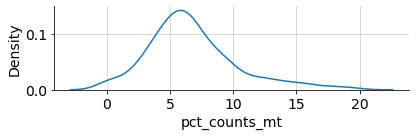

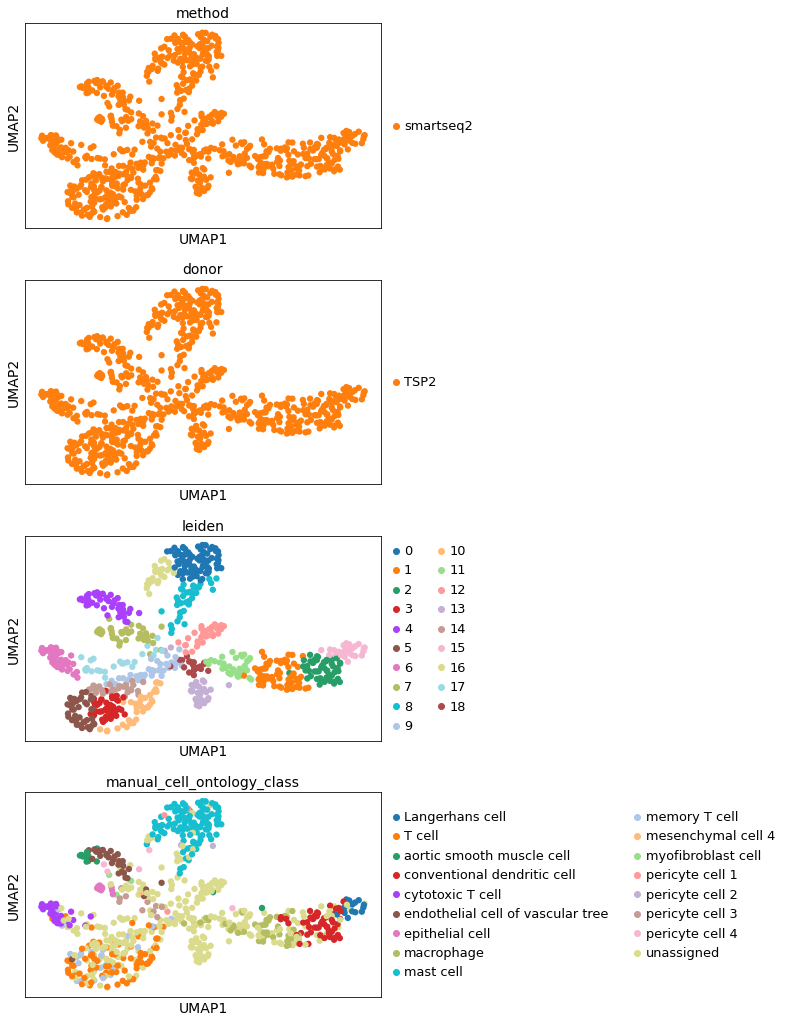

In [24]:
organ = "Skin"
organ_adata = adata[adata.obs["tissue"] == organ]

organ_adata.var['mt'] = organ_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(organ_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sns.displot(data=organ_adata.obs, x="pct_counts_mt", kind="kde", height=2, aspect=3)

# organ_adata = organ_adata[organ_adata.obs.pct_counts_mt < 20, :]

sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX", n_neighbors=15)
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=2)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [25]:
organ_adata

AnnData object with n_obs × n_vars = 739 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method',

In [26]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

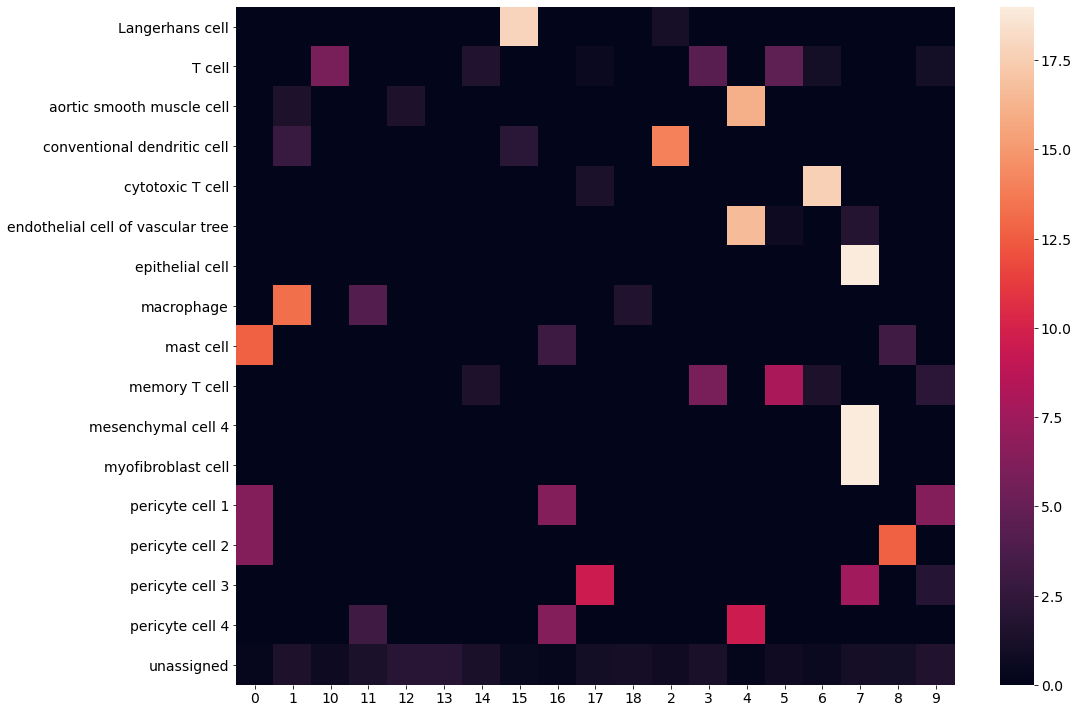

In [27]:
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap((count.T / count.mean(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [28]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [29]:
cluster_composition["8"]

['mast cell: 0.51', 'pericyte cell 2: 0.05', 'unassigned: 0.43']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [30]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [31]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

/home/angela/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [32]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


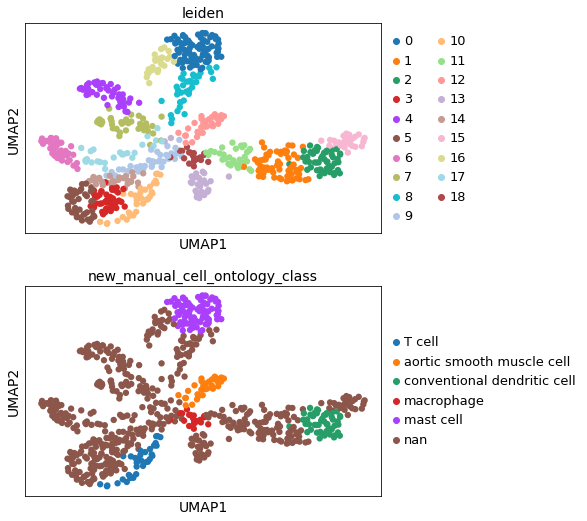

In [33]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

In [34]:
set(organ_adata.obs['Propagated.Annotation']),set(organ_adata.obs['manual_annotation'])

({'B cell',
  'CD4-positive helper T cell',
  'Langerhans cell',
  'T cell',
  'aortic smooth muscle cell',
  'conventional dendritic cell',
  'cytotoxic T cell',
  'endothelial cell of vascular tree',
  'epithelial cell',
  'fibroblast',
  'macrophage',
  'mast cell',
  'memory T cell',
  'myofibroblast cell',
  'pericyte cell 3',
  'pericyte cell 4'},
 {'Langerhans cell',
  'T cell',
  'aortic smooth muscle cell',
  'conventional dendritic cell',
  'cytotoxic T cell',
  'endothelial cell of vascular tree',
  'epithelial cell',
  'macrophage',
  'mast cell',
  'mesenchymal cell 4',
  'myofibroblast cell',
  'pericyte cell 1',
  'pericyte cell 2',
  'pericyte cell 3',
  'pericyte cell 4',
  'tissue-resident memory T cells',
  'unassigned'})

In [35]:
organ_adata.obs.groupby(['leiden']).agg({'new_manual_cell_ontology_class':set,'Propagated.Annotation':set})

,new_manual_cell_ontology_class,Propagated.Annotation
leiden,,
0,{mast cell},"{mast cell, aortic smooth muscle cell}"
1,{nan},"{macrophage, conventional dendritic cell, Lang..."
2,{conventional dendritic cell},"{macrophage, conventional dendritic cell, Lang..."
3,{nan},"{mast cell, memory T cell, T cell}"
4,{nan},"{endothelial cell of vascular tree, aortic smo..."
5,{nan},"{endothelial cell of vascular tree, memory T c..."
6,{nan},"{cytotoxic T cell, memory T cell, T cell}"
7,{nan},"{endothelial cell of vascular tree, pericyte c..."
8,{nan},"{endothelial cell of vascular tree, mast cell,..."


/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


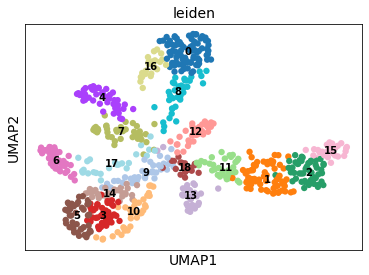

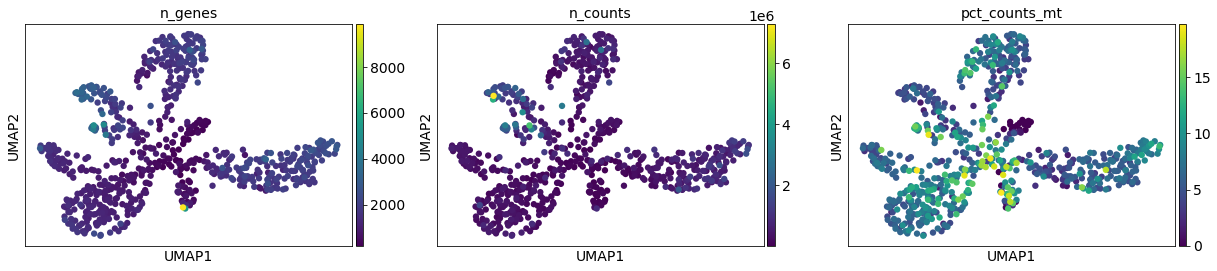

In [36]:
sc.pl.umap(organ_adata,color='leiden',legend_loc='on data')
sc.pl.umap(organ_adata,color=['n_genes','n_counts','pct_counts_mt'])


In [37]:
organ_adata.obs.columns

Index(['X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate',
       'smartseq2_sorting_direction', 'smartseq2_sort_order',
       'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate',
       'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes',
       'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position',
       'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class',
       'manual_annotation', 'doublet_filter', 'compartment', 'batch',
       'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation',
       'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps',
       'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet',
       'kNN', 'SVM', 'scANVI', 'compartment_pred_svm',
       'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed',
       'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed',
       'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized',
      

In [38]:
sc.tl.rank_genes_groups(organ_adata,'leiden',method='wilcoxon')

In [39]:
organ_cluster_genes = pd.DataFrame(organ_adata.uns['rank_genes_groups']['names'])
organ_cluster_genes.iloc[:20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,TPSAB1,TLR2,CCL22,CXCR4,EEF1A1,CNOT6L,CD96,MT2A,LMNA,CXCR4,TRBC1,RNASE1,MT1X,RF00100-4,RPS27,TMSB4XP4,KIT,CXCR4,ADGRG3
1,TPSB2,PID1,CD74,SARAF,TM4SF1,RORA,KLRK1,IFITM3,PHACTR4,RPS27,ARHGDIB,CTSL,VAMP8,RNU1-1,RPS19,TMSB4XP8,TPSAB1,SLC38A1,GLOD4
2,CPA3,CXCL8,IL4I1,IFITM1,EEF1A1P5,IL7R,GNLY,RPL7P9,RGS2,AC002075.2,CLEC2D,CD163,TSC22D1,RNU6-6P,AC005912.1,HLA-DQB1,TPSB2,FOS,PGGHG
3,KIT,C15orf48,CCR7,CNOT6L,EEF1A1P6,CXCR4,GZMB,RPL7,TPSB2,RPS27P21,PTPRC,CCL3,S100A16,RNU1-4,CXCR4,CST7,MELTF,CLK1,RF00601-2
4,IL1RL1,ETS2,HLA-DRA,CD69,SERPINE1,TXNIP,AREG,MT1X,SGK1,RPS7P1,CD3D,C1QB,PRELID1,RNU1-2,RPL21,HLA-DPB1,IL1RL1,CCNH,AC084824.2
5,HDC,IL1R2,HLA-DRB1,ARHGDIB,CAV1,LEPROTL1,LINC01871,SOD2,TPSAB1,RORA,CD2,CXCL1,SPTSSA,SNORD3A,RPS29,HLA-DQA1,PHACTR4,TUBA4A,AP003469.3
6,MELTF,EREG,HLA-DPA1,TSC22D3,RPL18AP3,RNF19A,SEPT11,MT-RNR1,TUBB4B,AC099336.2,CD7,C1QC,IDH2,PRMT9,AC002075.2,HLA-DPA1,HDC,NR4A1,CNOT10-AS1
7,RGS2,ACSL1,DUSP5,IL7R,SPARC,FYN,XCL1,RPL7P1,FUS,MRPL1,TRAC,MARCKS,LDHA,HIST1H2BN,RPL41P1,TMSB4X,ASAH1,JMY,AP001889.1
8,ASAH1,HLA-DRA,RNF144B,ZFP36L2,CD59,PTPRC,MPZL3,RPL23,AC129492.1,RPS17,IKZF3,ANPEP,MT1XP1,AC245014.3,RPL13A,HLA-DRB6,RGS2,ZFP36L2,HMGB3P26
9,PHACTR4,ATP13A3,HLA-DPB1,RORA,HSPB1,CD53,XCL2,RPL39P3,PLIN2,AC090602.1,FYB1,CXCL2,HMGA1,AL512646.1,BX679664.1,HLA-DQA2,CAPG,MPZL3,LINC00572


In [40]:
g = list(organ_cluster_genes["9"].head(10))
g = ",".join(g)
print(g)

CXCR4,RPS27,AC002075.2,RPS27P21,RPS7P1,RORA,AC099336.2,MRPL1,RPS17,AC090602.1


In [41]:
set(organ_adata.obs[organ_adata.obs['leiden']=='7']['manual_annotation'])

{'endothelial cell of vascular tree',
 'epithelial cell',
 'mesenchymal cell 4',
 'myofibroblast cell',
 'pericyte cell 3',
 'unassigned'}

In [48]:
cluster_composition["14"]

['T cell: 0.23', 'memory T cell: 0.07', 'unassigned: 0.70']

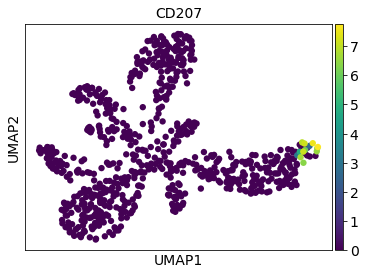

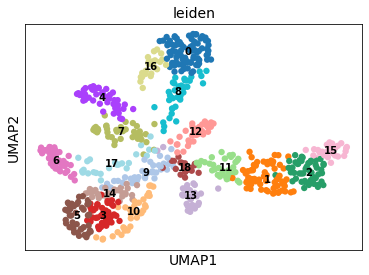

In [80]:
# sc.pl.umap(organ_adata,color=[ 'CD4','CD8A','CD3E','CD79A'],
#            ncols=2, cmap='Oranges') # t cells & b cells
# sc.pl.umap(organ_adata, color = ["CD3E","KLRB1"],
#            ncols=2, cmap='Oranges') # NK cells
# sc.pl.umap(organ_adata,color=[ 'CXCR4', 'CCR5',"NKG7"],ncols=2, cmap='Oranges') # t cell
# sc.pl.umap(organ_adata, color = ["AREG","KIT","RORA", "RORC", "IL1R1", "IL2RA",  "IL4", "IL5", "IL13","IL17B",  "GATA3", "NCR2", "CD34"],
#           ncols=2, cmap='Oranges') # inate immune cells

# sc.pl.umap(organ_adata,color=["CTSS", "TPSAB1"],ncols=2, cmap='Oranges') # mast cell

# sc.pl.umap(organ_adata,color=['DCLK1','VIM','ECM1','COL1A1','PDGFRB','PDGFRA'], cmap='Oranges')#'fibroblasts

# sc.pl.umap(organ_adata,color=[ 'PECAM1','TAGLN','CD93'],ncols=2, cmap='Oranges') # endothelial cells

# sc.pl.umap(organ_adata,
#            color=[ 'EPCAM','ITGA6','KRT5','KRT14','KRT10','KRT1',
#                   'CD34','LGR5','LGR6','LRIG1','ITGB1','TP63',
#                  'KLF4','PRDM1','KRT5'],
#            ncols=4, cmap='Oranges') # Goblet cells

# sc.pl.umap(organ_adata,color=[ 'CD207'],ncols=2) # langerhans cells
sc.pl.umap(organ_adata,color=[ 'CD14','CD68'],ncols=1) # macrophages
# # sc.pl.umap(organ_adata,color=[ 'CD44','CSPG4','PDGFRB', 'ACTA2','MYL9','MYH11'],ncols=2)
# # sc.pl.umap(organ_adata,color=['LYZ','DEFA1','FZD5','EPHB2','DLL1','WNT3','WNT11','EGF'])# paneth cells
# sc.pl.umap(organ_adata,color=['ID1'])#scratch list
sc.pl.umap(organ_adata,color='leiden',legend_loc='on data')

# sc.pl.umap(organ_adata,color='anatomical_position')

In [117]:
leiden_cell_type = {
    c"0": "mast cell", # KIT,TPSAB1
    "1": "monocyte/macrophage", # CD14, CD68, CD163,FABP5
    c"2": "mature dendritic cell", # HLA-DRA/B, CD208,CD83,CCR7
    c"3": "T cell", # CD3, TIGIT,CXCR4
    c"4": "endothelial cell", # PECAM1, DARC, CD93
    c"5": "T cell", # CD3, TIGIT
    c"6": "NK cell", # KLRK1,CD96,XCL1 NK cell like but does not express NCAM1
    c"7": "fibroblast", # low quality "Keratinocytes undifferentiated", # KRT14, DSC3,  ITGA6
    c"8": "mast cell", # TPSAB1
    c"9": "innate lymphoid cells", # CXCR4,TRAC RP genes
    c"10": "T cell", # CD3, TRBC1,TRAC	
    "11": "monocyte/macrophage", # CD14, CD68, CD163,FABP5
    c"12": "low quality -- remove",
    c"13": "low quality -- remove",
    c"14": "T cell", # low quality
    c"15": "Langerhans cell", # CD207
    c"16": "mast cell", # KIT,TPSAB1
    c"17": "innate lymphoid cells",
    c"18": "low quality -- remove",
}

In [73]:
adata.var_names[adata.var_names.str.startswith("LY")]

Index(['LYPLA2', 'LYSMD1', 'LY9', 'LYPLAL1-DT', 'LYPLAL1', 'LYPLAL1-AS1',
       'LYST', 'LYST-AS1', 'LYPD9P', 'LYPD8', 'LYARP1', 'LYG2', 'LYG1',
       'LYPD1', 'LYPD6B', 'LYPD6', 'LY75-CD302', 'LY75', 'LYZL4', 'LYAR',
       'LYPLA1P2', 'LYSMD3', 'LYRM7', 'LYRM4', 'LY86-AS1', 'LY86', 'LY6G5B',
       'LY6G5C', 'LY6G6F', 'LY6G6F-LY6G6D', 'LY6G6E', 'LY6G6D', 'LY6G6C',
       'LYPLA2P1', 'LYPLA1P3', 'LYRM2', 'LYPLA1P1', 'LYPLA1', 'LYN', 'LY96',
       'LY6K', 'LYPD2', 'LYNX1-SLURP2', 'LYNX1', 'LY6D', 'LY6E-DT', 'LY6E',
       'LY6L', 'LY6H', 'LYPLA2P3', 'LYZL1', 'LYZL2', 'LYVE1', 'LYZ', 'LYSMD2',
       'LYSMD4', 'LYRM1', 'LYRM9', 'LYZL6', 'LYPLA2P2', 'LYL1', 'LYPD4',
       'LYPD3', 'LYPD5'],
      dtype='object')

# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [118]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()


This cell will automatically replace the leiden cluster names with cell type annotations

In [120]:
for l in leiden_cell_type.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, leiden_cell_type[l], inplace=True)

# Visualize the results of the manual annotation

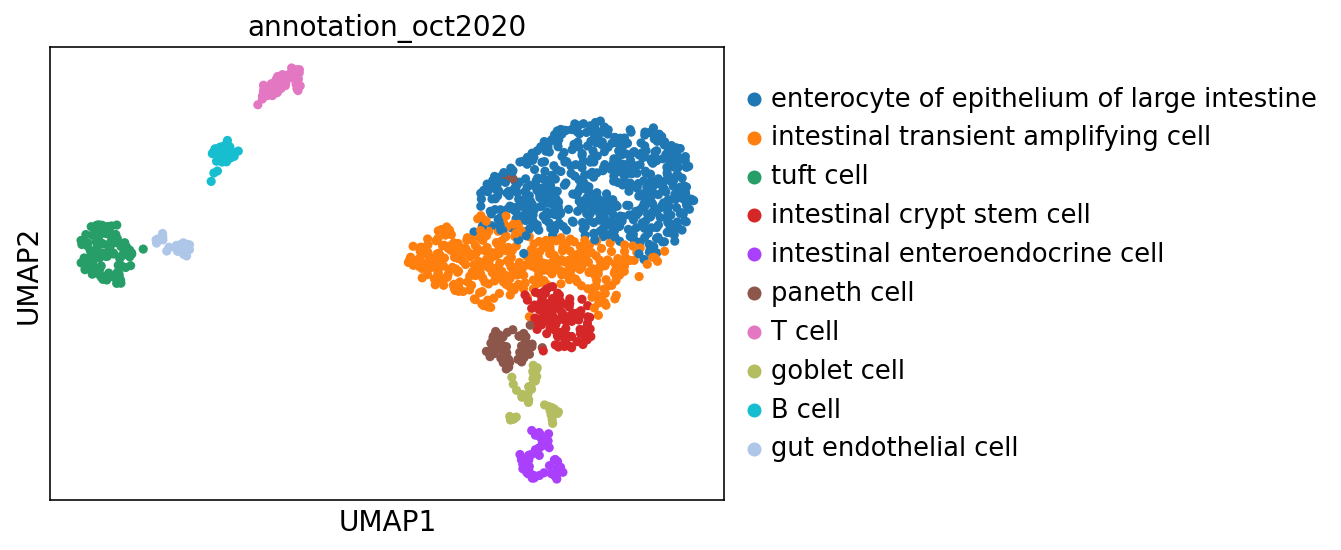

In [121]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# Subclustering

In [122]:
leiden13 = organ_adata[organ_adata.obs['leiden'].isin(["13"])].copy()
leiden13


/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 48 × 58870
    obs: 'X10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', 'X10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', 'X10X_sample', 'anatomical_position', 'X10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated.Annotation', 'Entropy.All.Methods', 'Entropy.kNN.Reps', 'Entropy.scANVI.Reps', 'Entropy.SVM.Reps', 'Potential.Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated.Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes', 'donor_method', 

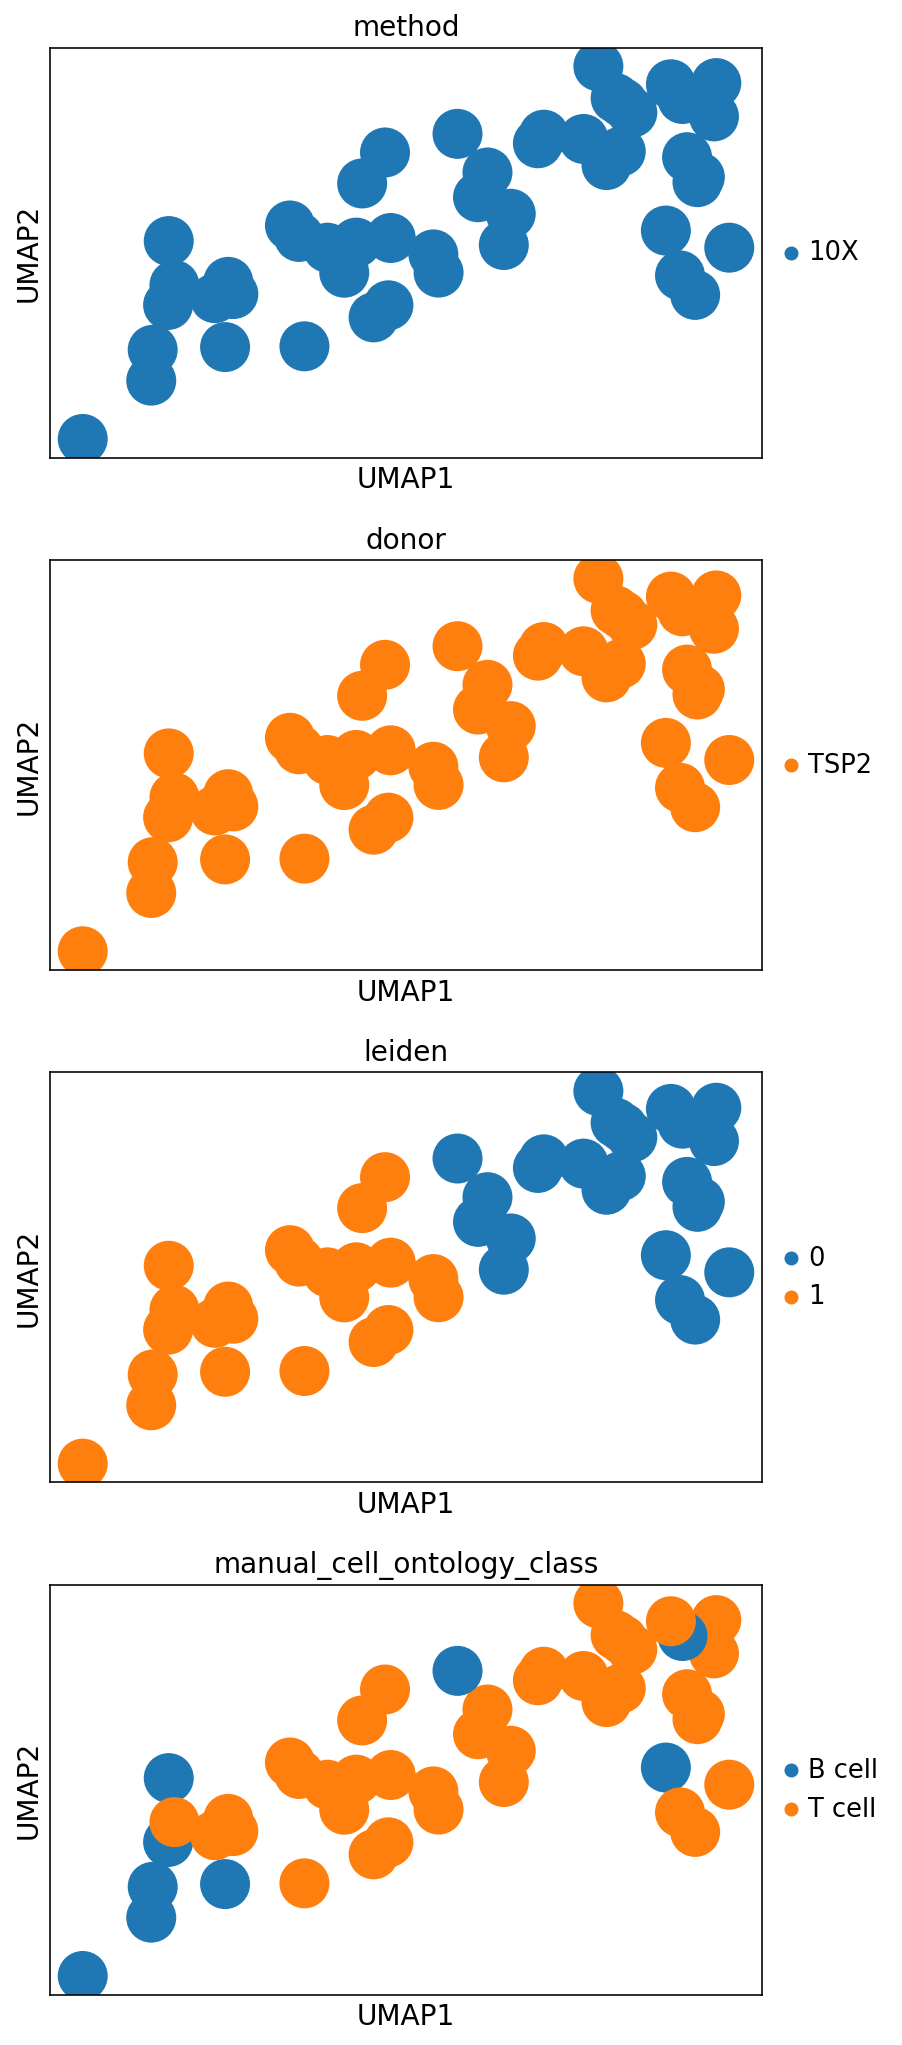

In [123]:
# sc.pp.neighbors(leiden13, use_rep="X_scvi_decontX")#, n_neighbors=10)
# sc.tl.umap(leiden13)
# leiden13.obsm["X_umap_decontX"] = leiden13.obsm["X_umap"].copy()
sc.tl.leiden(leiden13, resolution=.5)
sc.pl.umap(
    leiden13,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)

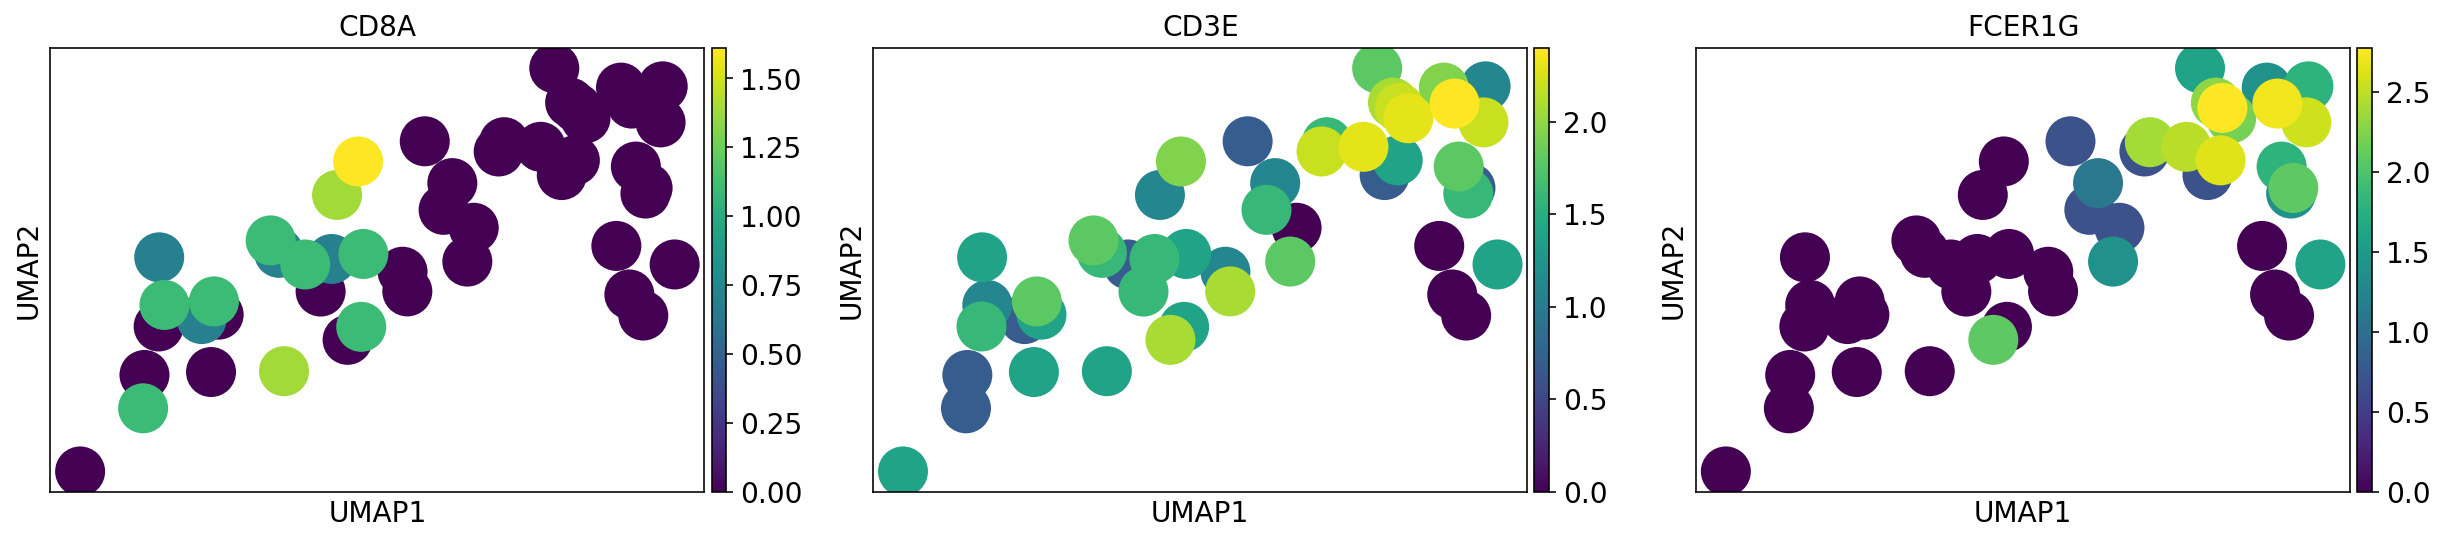

In [124]:
sc.pl.umap(leiden13,color=['CD8A','CD3E','FCER1G'])

In [128]:
organ_adata = remove_cats(organ_adata)

In [52]:
sc.tl.rank_genes_groups(leiden13,'leiden',method='wilcoxon')

In [53]:
pd.DataFrame(leiden13.uns['rank_genes_groups']['names']).iloc[:20]

,0,1
0,FCER1G,S100A4
1,GSTP1,CD3D
2,TYROBP,CD8A
3,CD247,BCL11B
4,TMIGD2,CD3G
5,CD63,CD8B
6,AREG,BATF
7,CEBPD,MGAT4A
8,IFITM2,IL7R
9,PSMB1,DNAJB1


In [129]:
c0_leiden13 = leiden13.obs[leiden13.obs["leiden"]=="0"].index
organ_adata.obs.loc[c0_leiden13,"annotation_oct2020"] = "double negative T cell"

c1_leiden13 = leiden13.obs[leiden13.obs["leiden"]=="1"].index
organ_adata.obs.loc[c1_leiden13,"annotation_oct2020"] = "CD8-positive, alpha-beta T cell"

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'X10X_run' as categorical
... storing 'smartseq2_barcode' as categorical
... storing 'smartseq2_library_plate' as categorical
... storing 'smartseq2_sorting_direction' as categorical
... storing 'smartseq2_sort_order' as categorical
... storing 'smartseq2_cDNA_Plate' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'X10X_replicate' as categorical
... storing 'sequencer' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'smartseq2_well_seq' as categorical
... storing 'notes' as categorical
... storing 'smartseq2_sorted_population' as categorical
... storing 'X10X_sample' as categorical
... storing 'anatomical_position' as cate

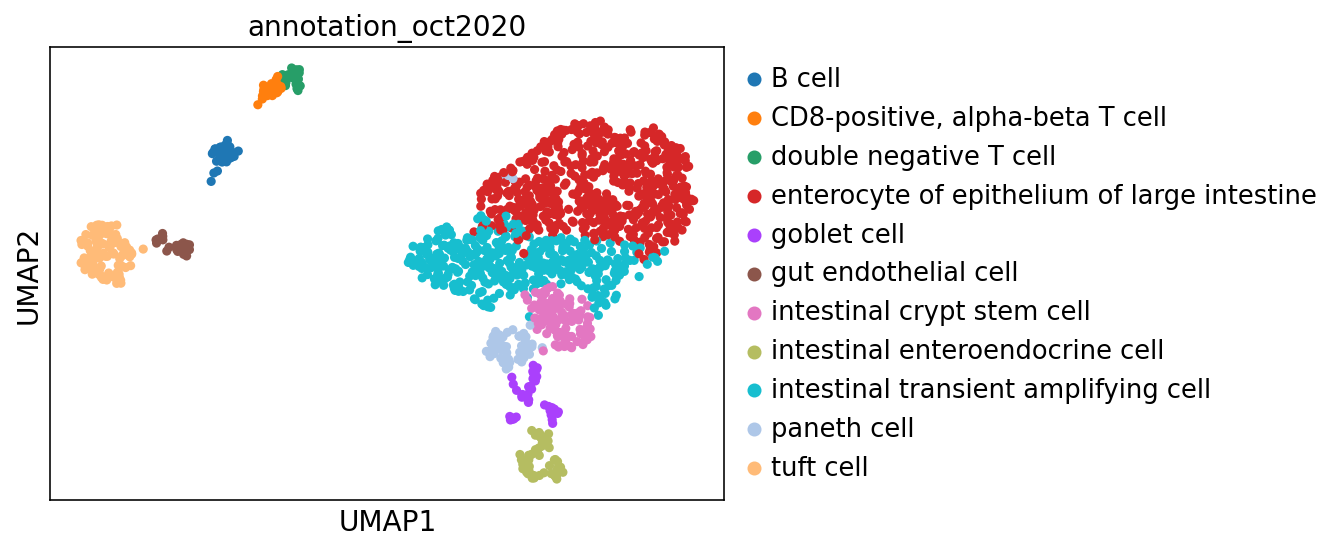

In [130]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# manually create mapping between cell type and compartment (this is just an example)

In [133]:
set(organ_adata.obs['annotation_oct2020'])

{'B cell',
 'CD8-positive, alpha-beta T cell',
 'double negative T cell',
 'enterocyte of epithelium of large intestine',
 'goblet cell',
 'gut endothelial cell',
 'intestinal crypt stem cell',
 'intestinal enteroendocrine cell',
 'intestinal transient amplifying cell',
 'paneth cell',
 'tuft cell'}

In [135]:
# options are Immune, Stromal, Epithelial, Endothelial
compartment_mapping = {
    'B cell': "Immune",
    'CD8-positive, alpha-beta T cell': "Immune",
    'double negative T cell': "Immune",
    'enterocyte of epithelium of large intestine': "Epithelial",
    'goblet cell': "Epithelial",
    'gut endothelial cell' : "Endothelial",
    'intestinal crypt stem cell': "Epithelial",
    'intestinal enteroendocrine cell': "Epithelial",
    'intestinal transient amplifying cell': "Epithelial",
    'paneth cell': "Epithelial",
    'tuft cell': "Epithelial"
}

In [136]:
organ_adata.obs["compartment_oct2020"] = organ_adata.obs["annotation_oct2020"].copy()

This cell will automatically replace the leiden cluster names with cell type annotations

In [137]:
for c in compartment_mapping.keys():
    organ_adata.obs["compartment_oct2020"].replace(
        c, compartment_mapping[c], inplace=True
    )

# Visualize the results of the new compartment splitting

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


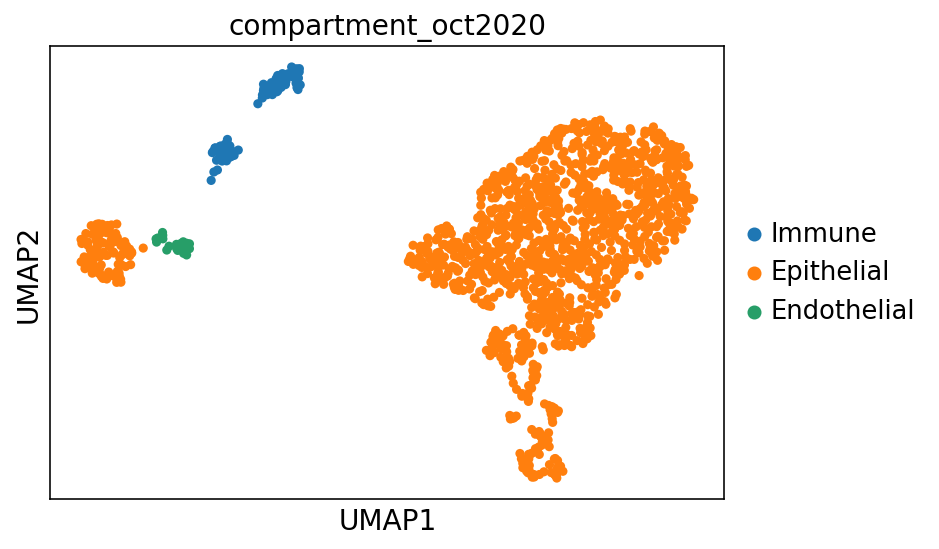

In [138]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# visualize compartment markers

In [141]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [142]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



/home/angela/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



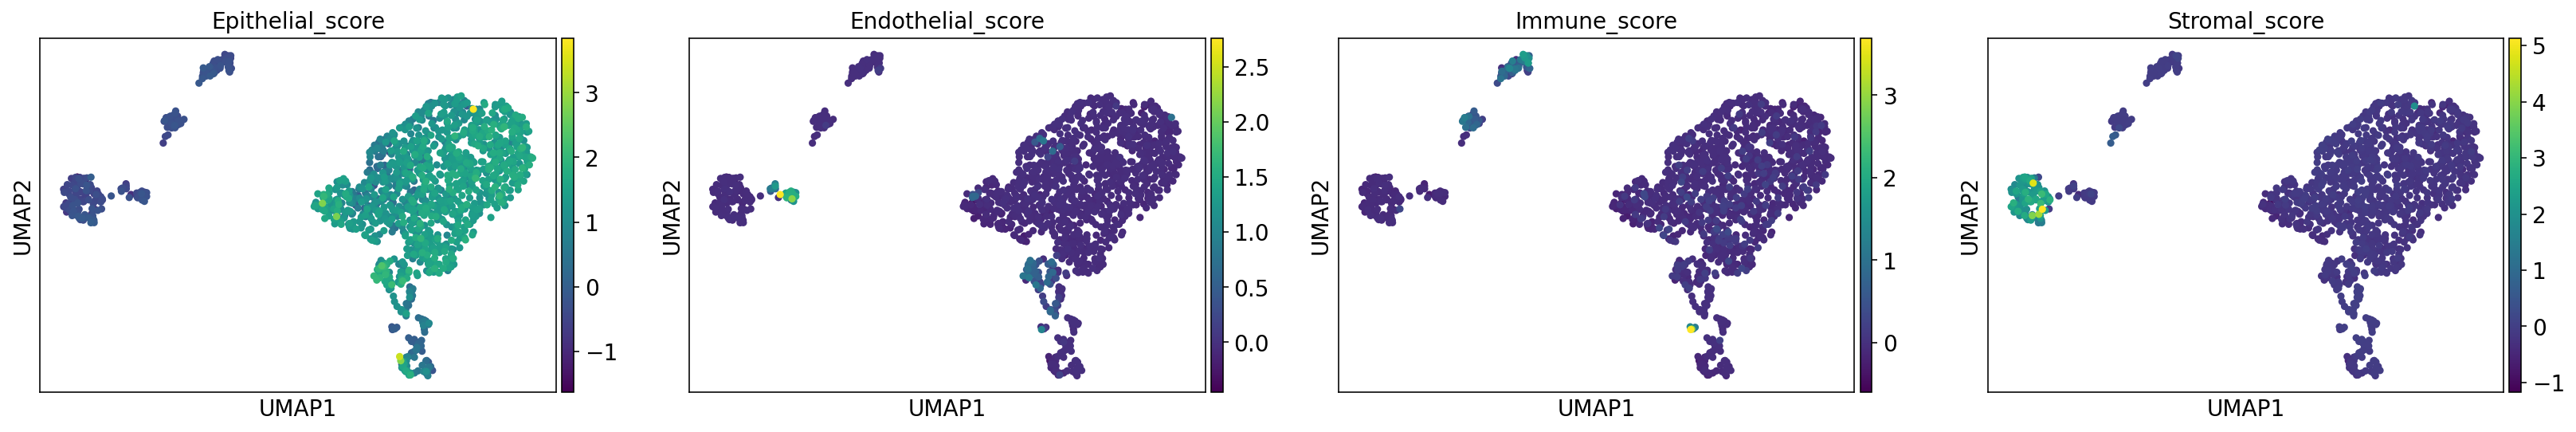

In [143]:
sc.pl.umap(
    organ_adata,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# read in cell ontology 

In [27]:
import obonet

ont_dir = "/data/yosef2/users/chenling/TabulaSapiensData/ontology/"
obo = ont_dir + "cl.obo.txt"
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

celltype_dict = {}
for x in co.nodes:
    celltype_dict[co.nodes[x]['name']] = x



You can look up all T cell by typing celltype_dict['T'] and using tab complete  

In [28]:
celltype_dict['T cell']

'CL:0000084'

You can also look at the names of all subsets of T cell that contains 'CD4' in their names

In [29]:
import networkx as nx


def PrintChildren(co, parent, pattern=""):
    all_children = [x for x in nx.ancestors(co, celltype_dict[parent])]
    return [co.nodes[x]["name"] for x in all_children if pattern in co.nodes[x]["name"]]


PrintChildren(co, "T cell", "CD4")

['CD4-negative CD8-negative gamma-delta intraepithelial T cell',
 'CD4-negative, CD8-negative type I NK T cell secreting interferon-gamma',
 'CD69-positive, CD4-positive single-positive thymocyte',
 'effector memory CD4-positive, alpha-beta T cell',
 'CD4-positive, alpha-beta memory T cell',
 'effector CD4-positive, alpha-beta T cell',
 'CD24-positive, CD4 single-positive thymocyte',
 'CD4-positive type I NK T cell secreting interferon-gamma',
 'CD4-positive type I NK T cell secreting interleukin-4',
 'CD4-positive, alpha-beta T cell',
 'CD4-positive type I NK T cell',
 'CD4-negative, CD8-negative type I NK T cell',
 'CD2-positive, CD5-positive, CD44-positive alpha-beta intraepithelial T cell',
 'activated CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell, human',
 'CD4-negative, CD8-negative type I NK T cell secreting interleukin-4',
 'CD4-positive, alpha-beta intraepithelial T cell',
 'mature CD4 single-positive thymocyte',
 'CD4-positive, CXCR3-negative, CCR6-

# save data

In [144]:
data_path

'/mnt/ibm_lg/angela/sapiens/data/'

In [146]:
organ_adata.write_h5ad(
    data_path + "decontX/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)